In [1]:
import keras
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv1D,UpSampling1D,MaxPooling1D,concatenate
from keras.layers import BatchNormalization
import keras.models as models
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
import tensorflow as tf
import keras.backend as K
from matplotlib import pyplot as plt
import random

import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split

import wandb
wandb.login()

2024-07-04 14:43:04.528401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lana-caldarevic1. Use `wandb login --relogin` to force relogin


True

In [2]:
def create_model(size_0, input_size, regularizer, dp):
	data_shape = input_size
	size_0=size_0
	size_1=size_0*2
	size_2=size_1*2
	kernel_size=27
	regularizer=regularizer
	dp=dp

	in_data= layers.Input(shape=(data_shape,1))
	conv0 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_data)
	conv0=BatchNormalization()(conv0)
	conv0 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
	conv0=BatchNormalization()(conv0)
	pool0 = MaxPooling1D(pool_size=2)(conv0)
	conv1 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
	conv1=BatchNormalization()(conv1)
	conv1_2 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
	conv1_2=BatchNormalization()(conv1_2)
	conv1_2=Dropout(dp)(conv1_2)
	pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
	conv2 = Conv1D(size_2, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1_2)
	conv2=BatchNormalization()(conv2)
	conv2 = Conv1D(size_2, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
	conv2=BatchNormalization()(conv2)
	up10 = Conv1D(size_2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv2))
	up10=BatchNormalization()(up10)
	merge10 = concatenate([conv1_2,up10], axis = 2)
	conv10 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
	conv10=BatchNormalization()(conv10)
	conv10 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	conv10=BatchNormalization()(conv10)
	conv10=Dropout(dp)(conv10)
	up10_1 = Conv1D(size_1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv10))
	up10_1=BatchNormalization()(up10_1)
	merge10_1 = concatenate([conv0,up10_1], axis = 2)
	conv10 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_1)
	conv10=BatchNormalization()(conv10)
	conv10 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	conv10=BatchNormalization()(conv10)
	out_data = Conv1D(1, kernel_size, activation = 'sigmoid', padding='same')(conv10)
	model = models.Model(inputs=[in_data], outputs=[out_data])
	#model=models.load_model('models/corr_model_'+size+'_'+str(lr)+'_'+str(dp)+'_'+str(regularizer)+'_.h5', custom_objects={'correlation': correlation,'new_mse':new_mse})
	model.summary()
	return model

In [3]:
def train(config=None, train=True):
    if config:
        wandb.init(config=config, project="fantasia-hp-tuning")
    else:
        wandb.init()
        config = wandb.config
        
    lr = wandb.config.learning_rate
    regularizer = wandb.config.regularizer
    dp = wandb.config.dp
    start_filters = wandb.config.start_filters

    adm = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    input_size = 1024
    
    model = create_model(start_filters, input_size, regularizer, dp)
    
    model.compile(loss='mse', metrics=[correlation, 'mse'], optimizer=adm)
    
    def log_representations_images(epoch, logs):
        wandb.log({
            "loss": logs['loss'],
            "CC": logs['correlation'],
            "mse": logs['mse'],
            "val_loss": logs['val_loss'],
            "val_CC": logs['val_correlation'],
            "val_mse": logs['val_mse']
        })
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Ground truth vs. Prediction')

        for row in range(2):
            train_idx = np.random.randint(0, windows_ecg_train.shape[0])
            val_idx = np.random.randint(0, windows_ecg_validation.shape[0])

            to_predict_train = np.array([windows_ecg_train[train_idx]])
            ground_truth_train = windows_resp_train[train_idx]
            prediction_train = model.predict(to_predict_train)[0]
            prediction_train_score = model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)

            to_predict_validation = np.array([windows_ecg_validation[val_idx]])
            ground_truth_validation = windows_resp_validation[val_idx]
            prediction_validation = model.predict(to_predict_validation)[0]
            prediction_validation_score = model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)

            ax[row, 0].plot(ground_truth_train, label='Ground Truth')
            ax[row, 0].plot(prediction_train, label='Prediction')
            ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f}")
            ax[row, 0].legend()

            ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
            ax[row, 1].plot(prediction_validation, label='Prediction')
            ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f}")
            ax[row, 1].legend()
    
        wandb.log({
            "predictions_visualization": wandb.Image(fig)
        }, commit=False)
        plt.close(fig)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    if train:
        print("model training starting")
        print(windows_ecg_train[:, :, :].shape)
        model.fit(
            windows_ecg_train[:, :, :], windows_resp_train[:, :, :],
            epochs=200,
            batch_size=256,
            shuffle=True,
            callbacks=[
                LambdaCallback(on_epoch_end=log_representations_images),
                early_stopping
            ],
            validation_data=(windows_ecg_validation[:, :, :], windows_resp_validation[:, :, :])
        )
    wandb.finish()
    return model

In [4]:
import tensorflow as tf

def correlation(x, y):
    min_y = tf.math.reduce_min(y)
    max_y = tf.math.reduce_max(y)
    r_up = tf.math.subtract(y, min_y)
    r_down = max_y - min_y
    new_y = r_up / r_down
    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    r_num = tf.reduce_sum(tf.multiply(xm, ym))
    r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(xm)), tf.reduce_sum(tf.square(ym))))
    r = r_num / r_den
    r = tf.maximum(tf.minimum(r, 1.0), -1.0)
    
    return 1 - r

In [5]:
import wfdb
import pandas as pd
import os
import numpy as np
def load_fantasia():
    files = os.listdir("/home/lcaldarevic/workspace/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []
    
    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/home/lcaldarevic/workspace/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        data_fantasia[participant] = np.array([data["ECG"], data["RESP"]])

    return data_fantasia, patients_fantasia

data, patients = load_fantasia()

In [6]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices, method='clipping'):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                # Normalize ECG using mean and std deviation
                normalized_ecg = (recrd_ecg - recrd_ecg.mean()) / recrd_ecg.std()
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))


    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [7]:
import neurokit2 as nk
sampling_rate = 250
def fill_nan_values(data):
    filled_data = {}
    for participant, signals in data.items():
        ecg_data = signals[0, :]
        resp_data = signals[1, :]

        ecg_filled = nk.signal_interpolate(ecg_data, method='linear')
        ecg_filled = nk.ecg_clean(ecg_filled, sampling_rate=sampling_rate, method="neurokit")
        
        resp_filled = nk.signal_interpolate(resp_data, method='linear')
        resp_filled = nk.rsp_clean(resp_filled, sampling_rate=sampling_rate)
        
        filled_data[participant] = np.vstack((ecg_filled, resp_filled))
    
    return filled_data

def check_for_nan(data, patients):
    for patient in patients:
        if np.isnan(data[patient]).any():
            print(f"NaN values found in patient data index: {patient}")

check_for_nan(data, patients)

data_filled = fill_nan_values(data)

check_for_nan(data_filled, patients)

NaN values found in patient data index: f2o10
NaN values found in patient data index: f2y09
NaN values found in patient data index: f2o06
NaN values found in patient data index: f2y10
NaN values found in patient data index: f2o09
NaN values found in patient data index: f2y01
NaN values found in patient data index: f2y08
NaN values found in patient data index: f2y05
NaN values found in patient data index: f2o05
NaN values found in patient data index: f2o02


In [8]:
seed = 0
train_val_patients, test_patients = train_test_split(patients, test_size=0.10, random_state=seed)
train_val_patients_array = np.array(train_val_patients)

train_patients, val_patients = train_test_split(train_val_patients, test_size=0.10, random_state=seed)

sampling_rate = 250
seconds_window = 16
downsampled_window_size = 1024 # signal size
window_size = sampling_rate * seconds_window # window size to split by

windows_ecg_train, windows_resp_train = process_data_segment(data_filled, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data_filled, window_size, downsampled_window_size, val_patients)
windows_ecg_test, windows_resp_test = process_data_segment(data_filled, window_size, downsampled_window_size, test_patients)

(28351, 1024, 1)
(28351, 1024, 1)
(3593, 1024, 1)
(3593, 1024, 1)
(3855, 1024, 1)
(3855, 1024, 1)


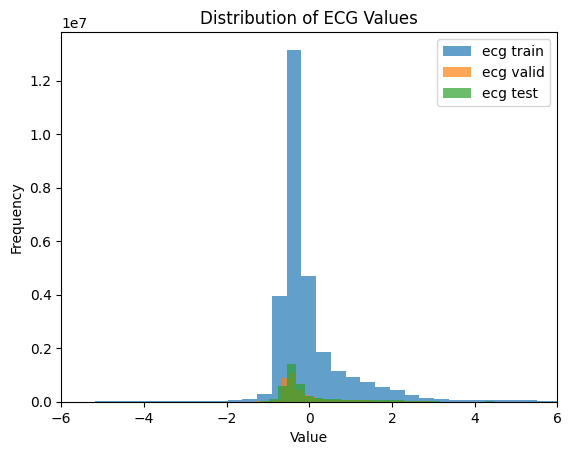

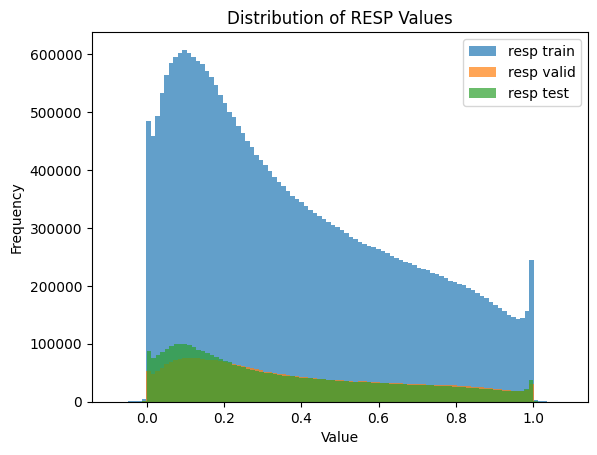

In [9]:
plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim([-6, 6]) 
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [24]:
config = dict(
    regularizer=0.0001,
    learning_rate=0.0001,
    dp=0.1,
    start_filters=4
)

In [25]:
model = train(config, train=False)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1024, 4)   │        112 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 512, 8)    │        872 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 256, 8)    │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 256, 16)   │      3,472 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_2     │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 512, 16)   │        528 │ up_sampling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

In [26]:
run_name = "youthful-sweep-6"
checkpoint_path = f"/home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/{run_name}.weights.h5"
model.load_weights(checkpoint_path)

/home/lcaldarevic/miniconda3/envs/tfgpu2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

AttributeError: 'Functional' object has no attribute 'history'

<Figure size 1000x500 with 0 Axes>

In [27]:
resp_predict_test = model.predict(windows_ecg_test)
resp_predict_train = model.predict(windows_ecg_train)
resp_predict_validation = model.predict(windows_ecg_validation)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [28]:
result = model.evaluate(windows_ecg_validation, windows_resp_validation)
loss, cc, mse = result

print(f"Valid Loss: {loss:.4f}")
print(f"Valid Correlation: {cc:.4f}")
print(f"Valid MSE: {mse:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - correlation: 0.3371 - loss: 0.0467 - mse: 0.0432
Valid Loss: 0.0492
Valid Correlation: 0.3527
Valid MSE: 0.0457


In [29]:
result = model.evaluate(windows_ecg_train, windows_resp_train)
loss, cc, mse = result

print(f"Train Loss: {loss:.4f}")
print(f"Train Correlation: {cc:.4f}")
print(f"Train MSE: {mse:.4f}")

886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - correlation: 0.2188 - loss: 0.0307 - mse: 0.0272
Train Loss: 0.0306
Train Correlation: 0.2105
Train MSE: 0.0271


In [30]:
result = model.evaluate(windows_ecg_test, windows_resp_test)
loss, cc, mse = result

print(f"Test Loss: {loss:.4f}")
print(f"Test Correlation: {cc:.4f}")
print(f"Test MSE: {mse:.4f}")

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - correlation: 0.3705 - loss: 0.0486 - mse: 0.0451
Test Loss: 0.0675
Test Correlation: 0.6024
Test MSE: 0.0640


In [31]:
def plot_signals_in_grid(predicted_signals, true_signals, labels=['Predicted', 'True']):
    fig, axs = plt.subplots(len(predicted_signals)//2, 2, figsize=(20, 50))
    axs = axs.flatten() 

    for i in range(len(predicted_signals)):  
        ax = axs[i]
        pred_signal = predicted_signals[i]
        true_signal = true_signals[i]

        #loss = tf.keras.losses.mse(pred_signal, true_signal)
        cc = correlation(pred_signal, true_signal)

        # Plotting both signals in the same subplot
        ax.plot(pred_signal, label=labels[0])
        ax.plot(true_signal, label=labels[1], alpha=0.75)
        ax.legend()
        ax.set_title(f'cc:  {cc}')
    
    plt.tight_layout()
    plt.show()

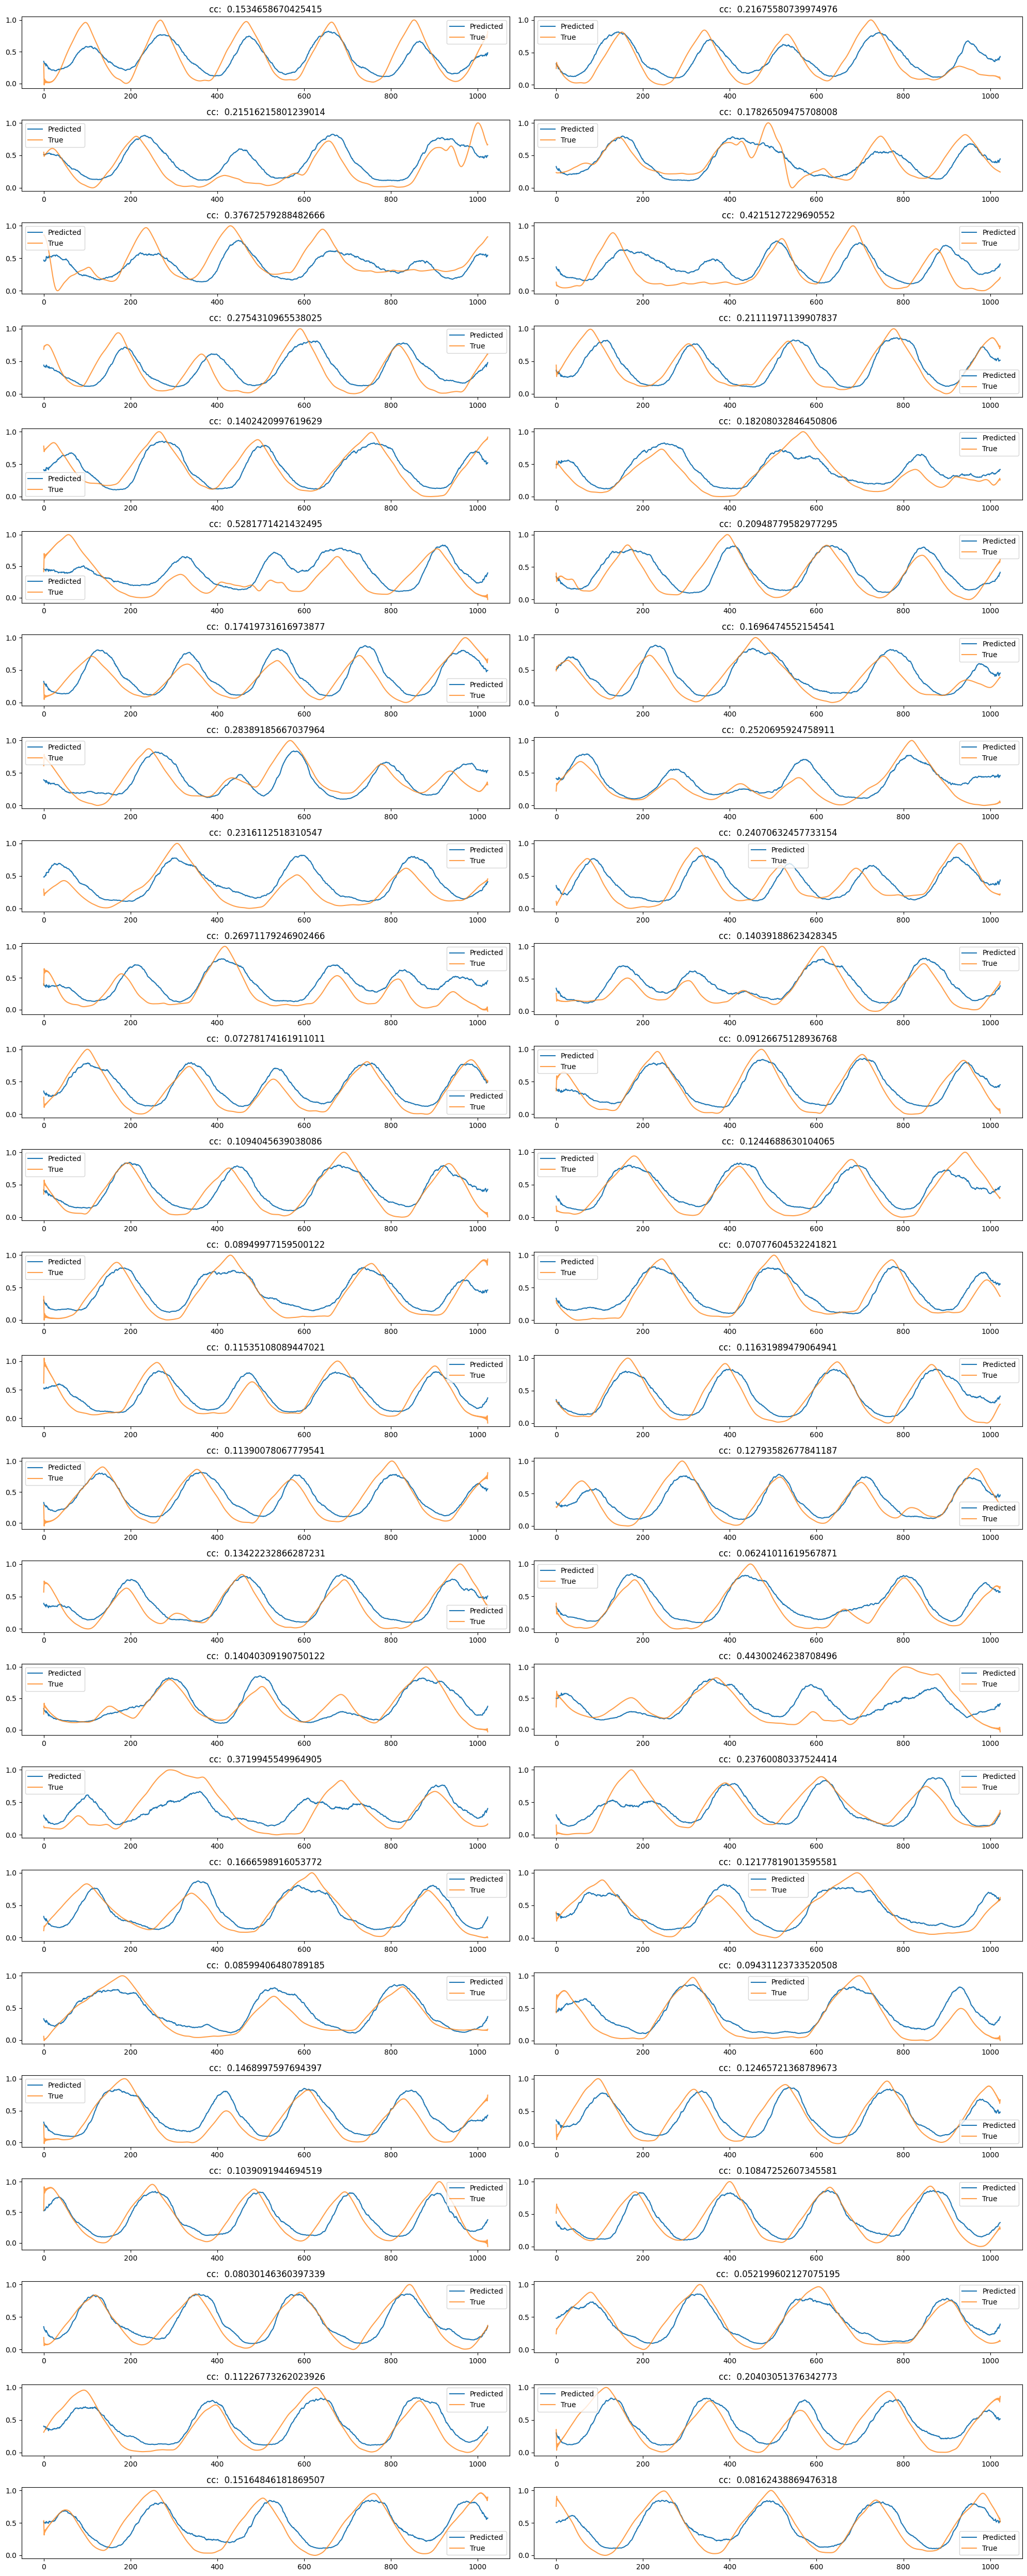

In [32]:
plot_signals_in_grid(resp_predict_test[0:50], windows_resp_test[0:50])

In [33]:
correlation(resp_predict_test, windows_resp_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.55297136>

In [21]:
#loss
tf.reduce_mean(tf.keras.losses.mse(windows_resp_test, resp_predict_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.06380673>

In [23]:
#mse
tf.reduce_mean(tf.square(windows_resp_test - resp_predict_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.06380673>

In [ ]:
Test Loss: 0.0664
Test Correlation: 0.6070
Test MSE: 0.0638